In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Veri Yükleme
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Veri Analizi ve Temizleme
# Eksik değerleri doldurma
for column in train.columns:
    if train[column].dtype == 'object':
        train[column] = train[column].fillna(train[column].mode()[0])
    else:
        train[column] = train[column].fillna(train[column].mean())

In [4]:
# Aykırı değer analizi (Örnek: GrLivArea)
q1 = train['GrLivArea'].quantile(0.25)
q3 = train['GrLivArea'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
train = train[(train['GrLivArea'] >= lower_bound) & (train['GrLivArea'] <= upper_bound)]

In [5]:
# Kategorik değişkenlerin one-hot encoding ile işlenmesi
train = pd.get_dummies(train, drop_first=True)

In [6]:
# Hedef ve Özelliklerin Ayrılması
X = train.drop(["Id", "SalePrice"], axis=1)
y = train["SalePrice"]

In [7]:
# Logaritmik dönüşüm (SalePrice)
y = np.log1p(y)

In [8]:
# Veriyi Eğitim ve Test Setlerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Model Eğitim ve Değerlendirme Fonksiyonu
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return r2, rmse, mae

In [10]:
# Modeller ve Performansları
models = {
    "Linear Regression": LinearRegression(),
    "SVM": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100)
}

results = {}

for model_name, model in models.items():
    r2, rmse, mae = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = {
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae
    }

In [11]:
# Performans Sonuçlarını Görselleştirme
results_df = pd.DataFrame(results).T
results_df["RMSE"] = np.expm1(results_df["RMSE"])
results_df["MAE"] = np.expm1(results_df["MAE"])
print(results_df)

                         R²      RMSE       MAE
Linear Regression  0.885498  0.135695  0.088544
SVM                0.703370  0.227286  0.155667
Decision Tree      0.652136  0.248307  0.169493
Random Forest      0.864394  0.148522  0.096011
Gradient Boosting  0.891225  0.132041  0.087110
XGBoost            0.859666  0.151274  0.096308


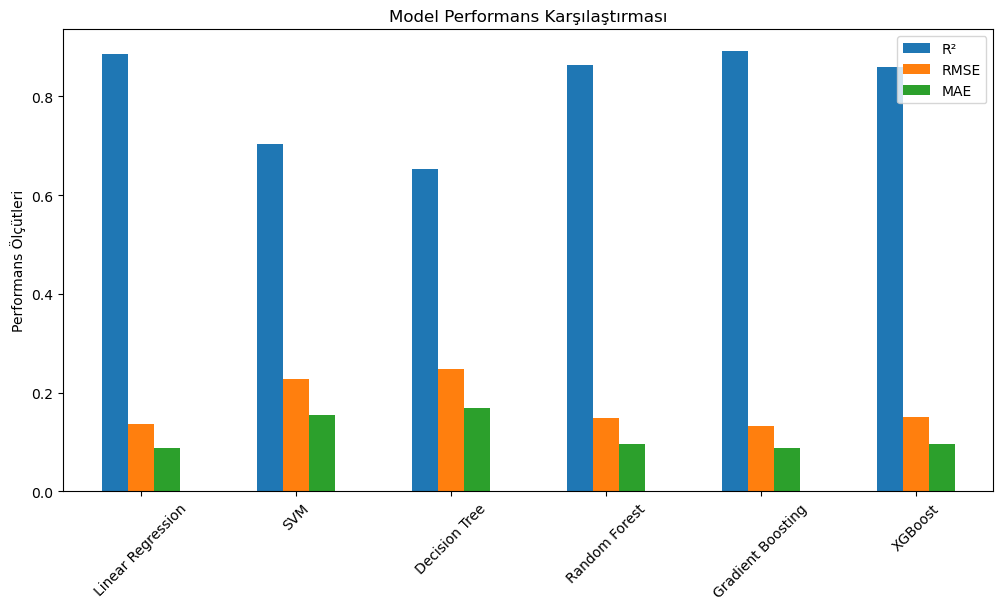

In [16]:
# Performans Grafiği
ax = results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Performans Ölçütleri')
plt.xticks(rotation=45)

# Grafiği kaydetme
plt.savefig('model_performance_comparisonlast.png', dpi=300, bbox_inches='tight')

# Grafiği gösterme
plt.show()


In [13]:
# Özellik Önem Dereceleri (Random Forest)
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
features = X_train.columns
feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

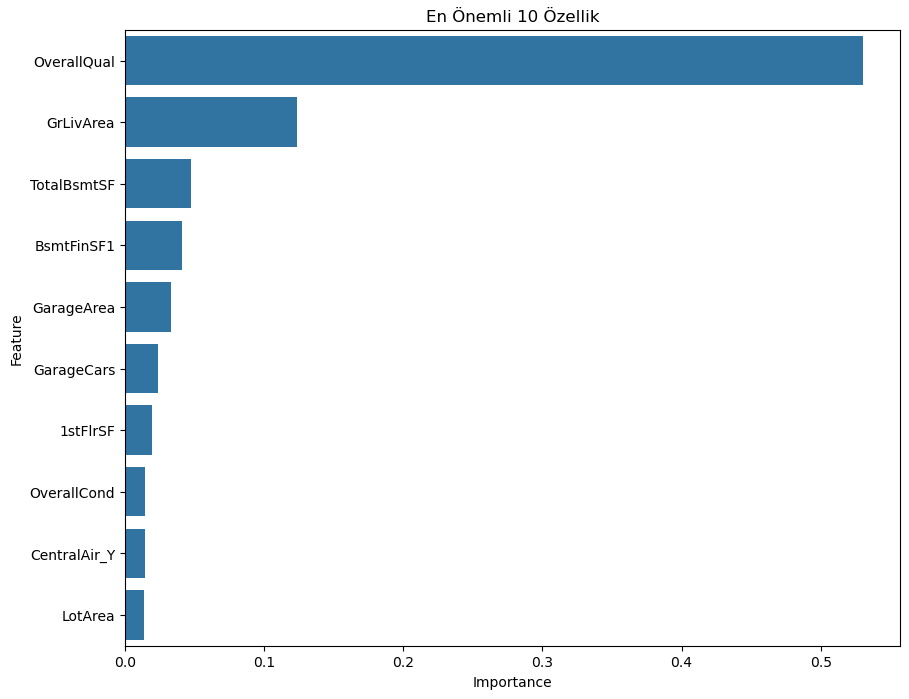

In [14]:
# Özellik Önem Grafiği
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importances[:10])
plt.title("En Önemli 10 Özellik")
plt.show()